In [13]:
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold, ShuffleSplit
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

import os
print(os.listdir("../input"))

['train.csv', 'sample_submission.csv', 'test.csv']


In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df
# courtesy of Guillaume Martin https://www.kaggle.com/gemartin

In [ ]:
# train_x = import_data('../input/train.csv')

In [14]:
train_x = pd.read_csv('../input/train.csv')

In [ ]:
# test_x = import_data('../input/test.csv')

In [15]:
test_x = pd.read_csv('../input/test.csv')

**EDA**

In [ ]:
train_x.isnull().sum()

In [4]:
eda = train_x.copy()

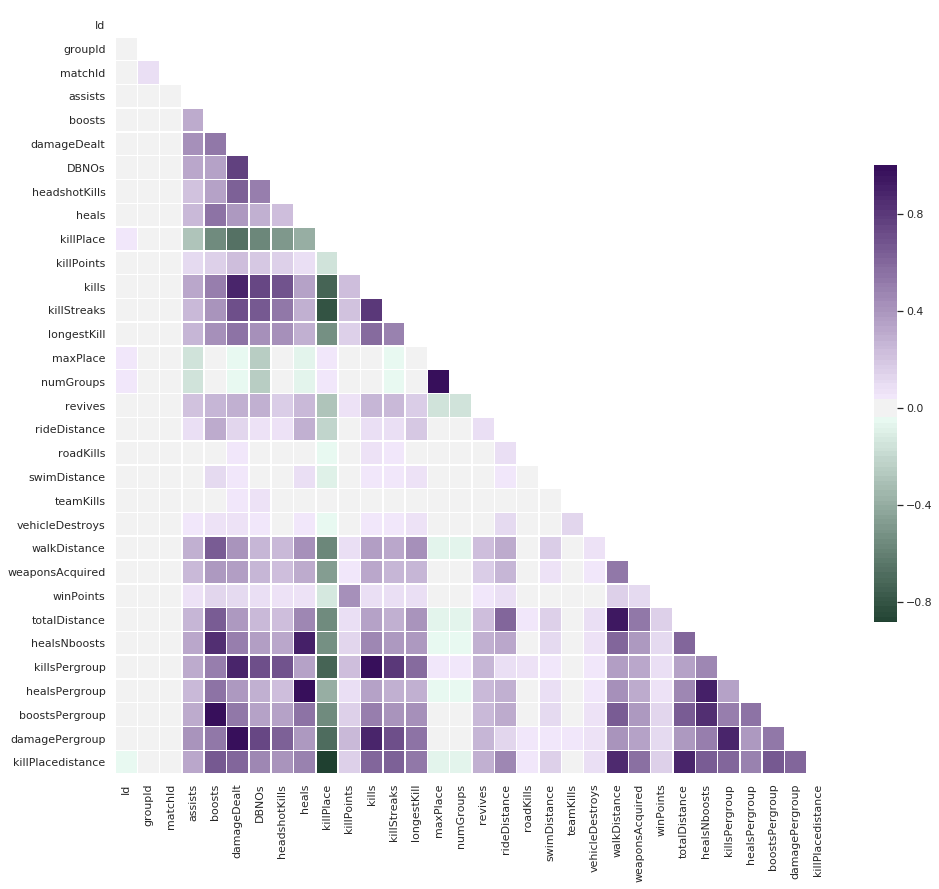

In [12]:
sns.set(style='whitegrid')
corr = train_x.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(16, 14))
cmap = sns.diverging_palette(145, 280, s=85, l=15, n=100)

sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5,
            cbar_kws={'shrink': .6})
plt.show()

In [ ]:
train_x.corr()

In [ ]:
'''
plot_data = train_x.sample(1000)
sns.set(style='ticks')
fig, ax = plt.subplots(figsize=(16,16))
sns.pairplot(plot_data, kind='reg')
'''

In [ ]:
eda.numGroups.hist(figsize=(15, 13), bins=100)

In [ ]:
print('Maximum number of groups: {}.'.format(eda.numGroups.max()))

In [ ]:
eda['matchType'] = 0
eda.loc[eda.numGroups < 101, 'matchType'] = 0  # solo
eda.loc[eda.numGroups < 51, 'matchType'] = 1  # duo
eda.loc[eda.numGroups < 34, 'matchType'] = 2  # tri
eda.loc[eda.numGroups < 26, 'matchType'] = 3  # quad

In [ ]:
fig, ax = plt.subplots(figsize=(15,13))
sns.pointplot(x="matchType", y='winPlacePerc', data=eda.sample(5000))
#  queuing quad has a lower win percentage

In [ ]:
fig, ax = plt.subplots(figsize=(15,13))
sns.scatterplot(x='winPlacePerc', y='revives', data=eda.sample(5000))
# slight correlation in winrate and number of revives

In [ ]:
print('Mean number of revives: {}'.format(eda.revives.mean()))
print('Maximum number of revives: {}'.format(eda.revives.max()))
# quite ridiculous number of revives, unless in custom matches

In [ ]:
fig, ax = plt.subplots(figsize=(15,13))
sns.distplot(eda.revives)

In [ ]:
fig, ax = plt.subplots(figsize=(15,13))
sns.distplot(eda.walkDistance)

In [ ]:
fig, ax = plt.subplots(figsize=(15,13))
sns.scatterplot(x='winPlacePerc', y='walkDistance', data=eda.sample(5000))
# high correlation in walk distance to winrate, which makes sense

In [ ]:
print("Mean distance walked: {}".format(eda['walkDistance'].mean()))
print("Maximum distance walked: {}".format(eda.walkDistance.max()))
# map size is 8x8 squares of 1km each, 17km of walking distance is very far

In [ ]:
fig, ax = plt.subplots(figsize=(15,13))
sns.scatterplot(x='winPlacePerc', y='swimDistance', data=eda.sample(5000))
# some correlation in swim distance to winrate

In [ ]:
print("Mean distance swimmed: {}".format(eda.swimDistance.mean()))
print("Maximum distance swimmed: {}".format(eda.swimDistance.max()))

In [ ]:
fig, ax = plt.subplots(figsize=(15,13))
sns.scatterplot(x='winPlacePerc', y='rideDistance', data=eda.sample(5000))
# some correlation in ride distance to winrate

In [ ]:
eda[['rideDistance', 'walkDistance', 'swimDistance', 'winPlacePerc']].corr()

In [ ]:
print("Mean distance rode: {}".format(eda.rideDistance.mean()))
print("Maximum distance rode: {}".format(eda.rideDistance.max()))
# riding 48km is riding across the map 6-7 times, which doesn't make much sense

In [ ]:
fig, ax = plt.subplots(figsize=(15,13))
sns.scatterplot(x='winPlacePerc', y='vehicleDestroys', data=eda.sample(5000))

In [ ]:
print("Mean vehicles destroyed: {}".format(eda.vehicleDestroys.mean()))
print("Maximum vehicles destroyed: {}".format(eda.vehicleDestroys.max()))

In [ ]:
fig, ax = plt.subplots(figsize=(15,13))
sns.scatterplot(x='kills', y='damageDealt', data=eda.sample(5000))

In [ ]:
fig, ax = plt.subplots(figsize=(16, 14))
sns.pointplot(x='kills', y='winPlacePerc', hue='matchType', data=eda.sample(10000))

In [ ]:
eda['damageCat'] = 0
eda.loc[eda.damageDealt < eda.damageDealt.max(), 'damageCat'] = 3
eda.loc[eda.damageDealt < 900, 'damageCat'] = 2
eda.loc[eda.damageDealt < 600, 'damageCat'] = 1
eda.loc[eda.damageDealt < 300, 'damageCat'] = 0

fig, ax = plt.subplots(figsize=(16, 14))
sns.pointplot(x='damageCat', y='winPlacePerc', hue='matchType', data=eda.sample(10000))

In [ ]:
print('Correlation between kills & damageDealt: {}'.format(eda[['kills', 'damageDealt']].corr()['kills'][1]))
print('Highest kill: {}'.format(eda.kills.max()))
# quite high correlation

In [ ]:
fig, ax = plt.subplots(figsize=(15,13))
sns.set(style='whitegrid')
sns.pointplot(x='heals', y='winPlacePerc', data=eda.sample(5000), color='blue', ax=ax)
sns.pointplot(x='boosts', y='winPlacePerc', data=eda.sample(5000), color='orange', ax=ax)
plt.xlabel('Heals/Boosts')
plt.text(0, 0.98, 'Heals', color='blue', fontsize=15)
plt.text(0, 1, 'Boosts', color='orange', fontsize=15)

In [ ]:
fig, ax = plt.subplots(figsize=(16, 14))
sns.pointplot(x='boosts', y='winPlacePerc', hue='matchType', data=eda.sample(10000))

In [ ]:
fig, ax = plt.subplots(figsize=(16, 14))
sns.pointplot(x='heals', y='winPlacePerc', hue='matchType', data=eda.sample(10000))

**Feature Cleaning**

In [16]:
def featureEngineer(dataset):
    dataset['matchType'] = 0
    dataset.loc[dataset.numGroups < 101, 'matchType'] = 0  # solo
    dataset.loc[dataset.numGroups < 51, 'matchType'] = 1  # duo
    dataset.loc[dataset.numGroups < 34, 'matchType'] = 2  # tri
    dataset.loc[dataset.numGroups < 26, 'matchType'] = 3  # quad
    dataset['matchType'] = dataset['matchType'].astype('category')

    dataset['totalDistance'] = dataset['walkDistance'] * 5 + dataset['rideDistance'] * 2 + dataset['swimDistance']  # higher importance for walkDist
    
    dataset['healsNboosts'] = dataset['heals'] + dataset['boosts'] * 1.2  # higher importance for boosts as compared to heals
    
    dataset['killsPergroup'] = 0  # kills not as important to winPlacePerc in larger groups matchmake
    dataset.loc[dataset.matchType == 0, 'killsPergroup'] = dataset['kills'] / 1
    dataset.loc[dataset.matchType == 1, 'killsPergroup'] = dataset['kills'] / 1.1
    dataset.loc[dataset.matchType == 2, 'killsPergroup'] = dataset['kills'] / 1.2
    dataset.loc[dataset.matchType == 3, 'killsPergroup'] = dataset['kills'] / 1.4

    dataset['healsPergroup'] = 0  # heals not as important to winPlacePerc in larger groups matchmake
    dataset.loc[dataset.matchType == 0, 'healsPergroup'] = dataset['heals'] / 1
    dataset.loc[dataset.matchType == 1, 'healsPergroup'] = dataset['heals'] / 1.05
    dataset.loc[dataset.matchType == 2, 'healsPergroup'] = dataset['heals'] / 1.10
    dataset.loc[dataset.matchType == 3, 'healsPergroup'] = dataset['heals'] / 1.15

    dataset['boostsPergroup'] = 0  # boosts not as important to winPlacePerc in larger groups matchmake
    dataset.loc[dataset.matchType == 0, 'boostsPergroup'] = dataset['boosts'] / 1
    dataset.loc[dataset.matchType == 1, 'boostsPergroup'] = dataset['boosts'] / 1.05
    dataset.loc[dataset.matchType == 2, 'boostsPergroup'] = dataset['boosts'] / 1.10
    dataset.loc[dataset.matchType == 3, 'boostsPergroup'] = dataset['boosts'] / 1.15

    dataset['damagePergroup'] = 0  # damageDealt not as important to winPlacePerc in larger groups matchmake
    dataset.loc[dataset.matchType == 0, 'damagePergroup'] = dataset['damageDealt'] / 1
    dataset.loc[dataset.matchType == 1, 'damagePergroup'] = dataset['damageDealt'] / 1.1
    dataset.loc[dataset.matchType == 2, 'damagePergroup'] = dataset['damageDealt'] / 1.2
    dataset.loc[dataset.matchType == 3, 'damagePergroup'] = dataset['damageDealt'] / 1.3
    
    dataset['killsPerdistance'] = dataset['kills'] / dataset['totalDistance']
    
    dataset['healsPerdistance'] = dataset['heals'] / dataset['totalDistance']
    
    dataset['boostsPerdistance'] = dataset['boosts'] / dataset['totalDistance']
    
    return dataset

In [17]:
def killPlacedistance(train_dataset, test_dataset):
    # feature measuring high distance travelled plus high kill rate
    fit_set = train_dataset[['killPlace', 'totalDistance']]
    
    std_scaler = StandardScaler()
    std_scaler.fit(fit_set)
    
    train_dataset['killPlaceS'] = 0
    test_dataset['killPlaceS'] = 0
    train_dataset['totalDistanceS'] = 0
    test_dataset['totalDistanceS'] = 0
    
    train_dataset[['killPlaceS', 'totalDistanceS']] = std_scaler.transform(train_dataset[['killPlace', 'totalDistance']])
    test_dataset[['killPlaceS', 'totalDistanceS']] = std_scaler.transform(test_dataset[['killPlace', 'totalDistance']])
    
    train_dataset['killPlacedistance'] = train_dataset['totalDistanceS'] - train_dataset['killPlaceS']
    test_dataset['killPlacedistance'] = test_dataset['totalDistanceS'] - test_dataset['killPlaceS']
    
    train_dataset.drop('killPlaceS', axis=1, inplace=True)
    train_dataset.drop('totalDistanceS', axis=1, inplace=True)
    test_dataset.drop('killPlaceS', axis=1, inplace=True)
    test_dataset.drop('totalDistanceS', axis=1, inplace=True)

    return train_dataset, test_dataset    

In [19]:
def dropFeatures(dataset):
    dataset.drop(['Id', 'groupId', 'matchId', 'heals', 'boosts', 'walkDistance', 'rideDistance', 'swimDistance', 'maxPlace', 'kills'], axis=1, inplace=True)
    
    return dataset

**Clean Data**

In [20]:
train_x = featureEngineer(train_x)
test_x = featureEngineer(test_x)
train_y = train_x.pop('winPlacePerc')

train_x, test_x = killPlacedistance(train_x, test_x)

train_x = dropFeatures(train_x)
test_x = dropFeatures(test_x)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  del sys.path[0]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [22]:
x = train_x
y = train_y
xt = test_x

**Model Building**

In [ ]:
'''
params = [
    {'n_estimators': [50, 100], 'max_features': [8, 12]},
    {'bootstrap': [False]}
]
forest_reg = RandomForestRegressor(random_state=0, min_samples_leaf=20)
grid_search = GridSearchCV(forest_reg, params, cv=5, scoring='neg_mean_absolute_error')
'''

In [ ]:
'''
grid_search.fit(train_x, train_y)
cvres = grid_search.cv_results_
for mean_score, params in sorted(zip(cvres['mean_test_score'], cvres['params'])):
    print(-mean_score, params)
'''

In [ ]:
'''
forest_reg = RandomForestRegressor(n_estimators=100, random_state=0, min_samples_leaf = 10, max_features=12, bootstrap=True)
forest_reg.fit(train_x, train_y)
prediction = forest_reg.predict(test_x)
'''

In [23]:
max_rounds = 10000
ss = ShuffleSplit(n_splits=1, test_size=0.2)
for train_index, test_index in ss.split(x, y):
    x_train, y_train = x.iloc[train_index], y.iloc[train_index]
    x_val, y_val = x.iloc[test_index], y.iloc[test_index]
    
    params = {
        'objective': 'regression',
        'learning_rate': 0.08,
        'bagging_fraction': 0.8,
        'min_data_in_leaf': 100,
        'metric': 'l1'
    }
    
    train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=['matchType'])
    eval_dataset = lgb.Dataset(x_val, label=y_val, categorical_feature=['matchType'])
    
    # train model
    lgb_reg = lgb.train(params, train_set=train_dataset, num_boost_round=max_rounds,
                       valid_sets=eval_dataset, early_stopping_rounds=200, verbose_eval=50)

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[50]	valid_0's l1: 0.0718539
[100]	valid_0's l1: 0.0667875
[150]	valid_0's l1: 0.065554
[200]	valid_0's l1: 0.0649439
[250]	valid_0's l1: 0.06461
[300]	valid_0's l1: 0.0643645
[350]	valid_0's l1: 0.0642043
[400]	valid_0's l1: 0.064079
[450]	valid_0's l1: 0.0639747
[500]	valid_0's l1: 0.063888
[550]	valid_0's l1: 0.0638217
[600]	valid_0's l1: 0.0637518
[650]	valid_0's l1: 0.0637015
[700]	valid_0's l1: 0.0636507
[750]	valid_0's l1: 0.0636251
[800]	valid_0's l1: 0.0635728
[850]	valid_0's l1: 0.0635516
[900]	valid_0's l1: 0.0635157
[950]	valid_0's l1: 0.0634868
[1000]	valid_0's l1: 0.0634658
[1050]	valid_0's l1: 0.0634459
[1100]	valid_0's l1: 0.0634255
[1150]	valid_0's l1: 0.0634139
[1200]	valid_0's l1: 0.0633922
[1250]	valid_0's l1: 0.0633757
[1300]	valid_0's l1: 0.0633624
[1350]	valid_0's l1: 0.0633437
[1400]	valid_0's l1: 0.0633296
[1450]	valid_0's l1: 0.0633186
[1500]	valid_0's l1: 0.0633096
[1550]	valid_0's l1: 0.0632971
[

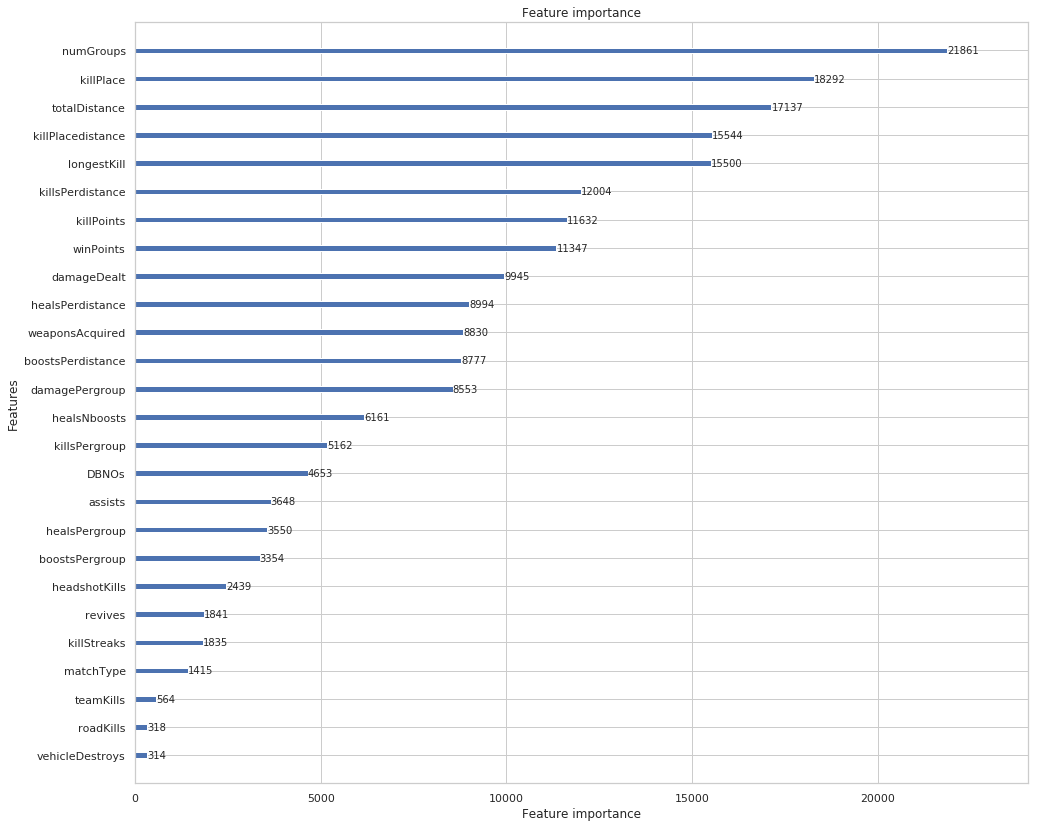

In [24]:
fig, ax = plt.subplots(figsize=(16, 14))
ax = lgb.plot_importance(lgb_reg, ax=ax)

In [ ]:
prediction = lgb_reg.predict(xt, num_iteration=lgb_reg.best_iteration or max_rounds)

In [ ]:
submission = pd.read_csv('../input/sample_submission.csv')
submission['winPlacePerc'] = np.clip(prediction, 0, 1)
submission.to_csv('submissionlgb.csv', index=False)